# Double Factorization

Bloqs for the double-factorized chemistry Hamiltonian in second quantization.

Recall that for the single factorized Hamiltonian we have
$$
    H = \sum_{pq}T'_{pq} a_p^\dagger a_q + \frac{1}{2} \sum_l \left(\sum_{pq}
W_{pq}^{(l)} a_p^\dagger a_q\right)^2.
$$
One arrives at the double factorized (DF) Hamiltonian by further factorizing the
$W_{pq}^{(l)}$ terms as
$$
    W^{(l)}_{pq} = \sum_{k} U^{(l)}_{pk} f_k^{(l)} U^{(l)*}_{qk},
$$
so that
$$
    H = \sum_{pq}T'_{pq} a_p^\dagger a_q + \frac{1}{2} \sum_l U^{(l)}\left(\sum_{k}^{\Xi^{(l)}}
        f_k^{(l)} n_k\right)^2 U^{(l)\dagger}
$$
where $\Xi^{(l)} $ is the rank of second factorization.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `DoubleFactorizationOneBody`
Block encoding of double factorization one-body Hamiltonian.

Implements inner "half" of Fig. 15 in the reference. This block encoding is
applied twice (with a reflection around the inner state preparation
registers) to implement (roughly) the square of this one-body operator.

#### Parameters
 - `num_aux`: Dimension of auxiliary index for double factorized Hamiltonian. Call L in Ref[1].
 - `num_spin_orb`: The number of spin orbitals. Typically called $N$.
 - `num_eig`: The total number of eigenvalues.
 - `num_bits_state_prep`: The number of bits of precision for coherent alias sampling. Called $\aleph$ in the reference.
 - `num_bits_rot_aa_outer`: Number of bits of precision for single qubit rotation for amplitude amplification. Called $b_r$ in the reference.
 - `num_bits_rot`: Number of bits of precision for rotations for amplitude amplification in uniform state preparation. Called $\beth$ in Ref[1]. 

#### Registers
 - `succ_l`: control for success for outer state preparation.
 - `succ_p`: control for success for inner state preparation, this is reused in second application.
 - `l_ne_zero`: control for one-body part of Hamiltonian.
 - `xi`: data register for number storing $\Xi^{(l)}$.
 - `p`: Register for inner state preparation.
 - `rot_aa`: A qubit to be rotated for amplitude amplification.
 - `spin`: A single qubit register for spin superpositions.
 - `xi`: Register for rank parameter.
 - `offset`: Offset for p register.
 - `rot`: Amplitude amplification angles for inner preparations.
 - `rotations`: Rotations for basis rotations.
 - `sys`: The system register. 

Refererences:
    [Even More Efficient Quantum Computations of Chemistry Through Tensor
        Hypercontraction](https://arxiv.org/abs/2011.03494)

In [2]:
from qualtran.bloqs.chemistry.df.double_factorization import DoubleFactorizationOneBody

### Example Instances

In [3]:
num_bits_state_prep = 12
num_bits_rot = 7
num_spin_orb = 10
num_aux = 50
num_eig = num_aux * (num_spin_orb // 2)
df_one_body = DoubleFactorizationOneBody(
    num_aux=num_aux,
    num_spin_orb=num_spin_orb,
    num_eig=num_eig,
    num_bits_state_prep=num_bits_state_prep,
    num_bits_rot=num_bits_rot,
)

#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([df_one_body],
           ['`df_one_body`'])

### Call Graph

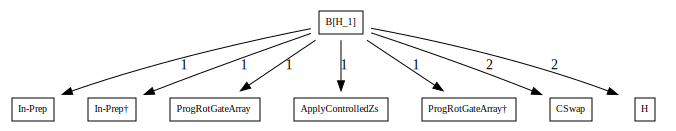

#### Counts totals:
 - `ApplyControlledZs`: 1
 - `CSwap`: 2
 - `H`: 2
 - `In-Prep`: 1
 - `In-Prep†`: 1
 - `ProgRotGateArray`: 1
 - `ProgRotGateArray†`: 1

In [5]:
from qualtran.resource_counting.generalizers import ignore_split_join
df_one_body_g, df_one_body_sigma = df_one_body.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(df_one_body_g)
show_counts_sigma(df_one_body_sigma)

## `DoubleFactorizationBlockEncoding`
Block encoding of double factorization Hamiltonian.

Implements Fig. 15 in the reference.

#### Parameters
 - `num_spin_orb`: The number of spin orbitals. Typically called $N$.
 - `num_aux`: Dimension of auxiliary index for double factorized Hamiltonian. Typically called $L$.
 - `num_eig`: The total number of eigenvalues.
 - `num_bits_state_prep`: The number of bits of precision for coherent alias sampling. Called $\aleph$ in Ref[1]. We assume this is the same for both outer and inner state preparations.
 - `num_bits_rot`: Number of bits of precision for rotations amplification in uniform state preparation. Called $\beth$ in Ref[1].
 - `num_bits_rot_aa_outer`: Number of bits of precision for single qubit rotation for amplitude amplification in outer state preparation. Called $b_r$ in the reference. Keeping inner and outer separate for consistency with openfermion.
 - `num_bits_rot_aa_inner`: Number of bits of precision for single qubit rotation for amplitude amplification in inner state preparation. Called $b_r$ in the reference. 

#### Registers
 - `ctrl`: Registers used to control application of Hamiltonian terms / preparation.
 - `l`: Register for outer state preparation.
 - `p`: Register for inner state preparation.
 - `rot_aa`: A qubit to be rotated for amplitude amplification.
 - `spin`: A single qubit register for spin superpositions.
 - `xi`: Register for rank parameter.
 - `offset`: Offset for p register.
 - `rot`: Amplitude amplification angles for inner preparations.
 - `rotations`: Rotations for basis rotations.
 - `sys`: The system register. 

Refererences:
    [Even More Efficient Quantum Computations of Chemistry Through Tensor
        hypercontraction](https://arxiv.org/abs/2011.03494)

In [6]:
from qualtran.bloqs.chemistry.df.double_factorization import DoubleFactorizationBlockEncoding

### Example Instances

In [7]:
num_spin_orb = 10
num_aux = 50
num_eig = num_aux * (num_spin_orb // 2)
num_bits_state_prep = 12
num_bits_rot = 7
df_block_encoding = DoubleFactorizationBlockEncoding(
    num_spin_orb=num_spin_orb,
    num_aux=num_aux,
    num_eig=num_eig,
    num_bits_state_prep=num_bits_state_prep,
    num_bits_rot_aa_outer=1,
    num_bits_rot_aa_inner=7,
    num_bits_rot=num_bits_rot,
)

#### Graphical Signature

In [8]:
from qualtran.drawing import show_bloqs
show_bloqs([df_block_encoding],
           ['`df_block_encoding`'])

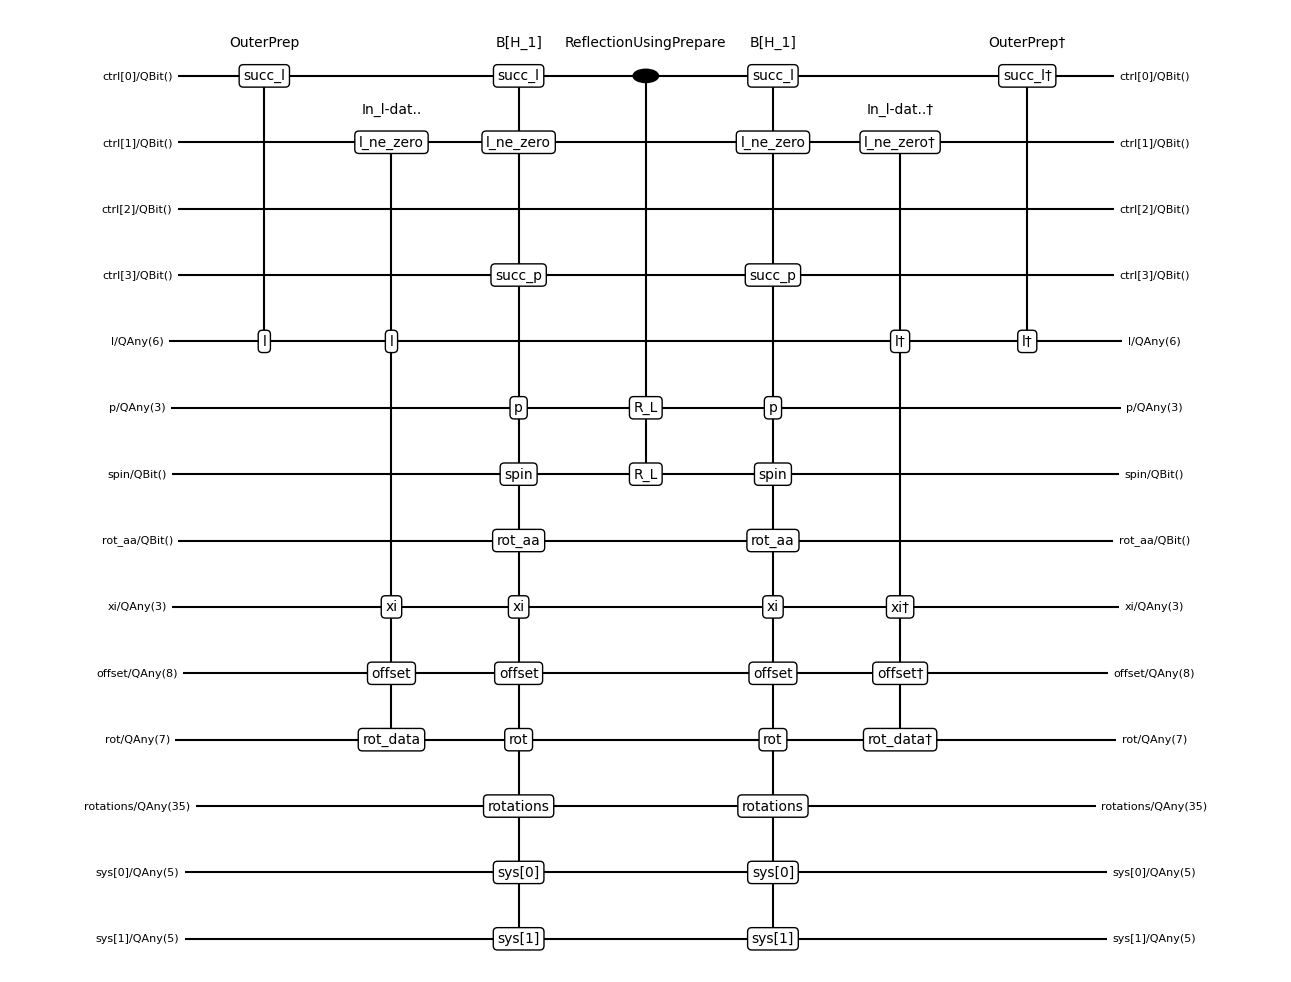

In [9]:
from qualtran.drawing import get_musical_score_data, draw_musical_score
msd = get_musical_score_data(df_block_encoding.decompose_bloq())
fig, ax = draw_musical_score(msd)
fig.set_size_inches(14, 10)

### Call Graph

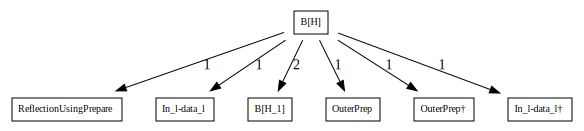

#### Counts totals:
 - `B[H_1]`: 2
 - `In_l-data_l`: 1
 - `In_l-data_l†`: 1
 - `OuterPrep`: 1
 - `OuterPrep†`: 1
 - `ReflectionUsingPrepare`: 1

In [10]:
from qualtran.resource_counting.generalizers import ignore_split_join
df_block_encoding_g, df_block_encoding_sigma = df_block_encoding.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(df_block_encoding_g)
show_counts_sigma(df_block_encoding_sigma)